# Detect mismatching between DL and UV core photos

* [Task](#Task)
* [Dataset](#Dataset)
* [Architecture](#Architecture)
* [Training](#Training)
* [Validation](#Validation)
* [Training and inference time](#Training-and-inference-time)
* [Criticism](#Criticism)

## Task

Find all pairs of DL (daylight) and UV (ultraviolet) core photos which don't correspond each other perfectly (have shifts, flips, stretching or completely mismatch)

## Dataset

Dataset consists of 11 wells (totally 768 core photos). Each well is represented by the set of DL and UV photos and labels for each pair: 1 means that pair has defects, 0 otherwise.

Example of good pair:

In [1]:
from utils import *

plot_pair('/notebooks/data/images_matching/processed_dataset/417по', '417по_2356.58_2357.56.png')

<Figure size 500x1500 with 2 Axes>

Example of bad pair:

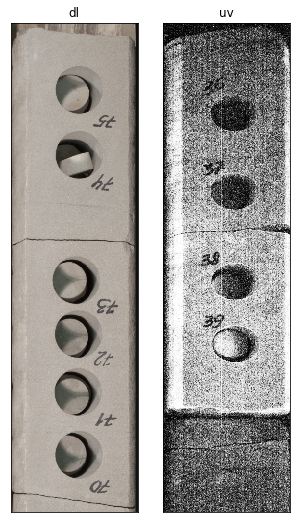

In [2]:
plot_pair('/notebooks/data/images_matching/processed_dataset/417по', '417по_2360.6_2361.35.png')

For data preprocessing and model training we create `CoreBatch` which include loaders and augmentations.

In [3]:
import os
import sys
import glob

from PIL import Image

sys.path.insert(0, os.path.join("..", "..", ".."))

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from well_logs import CoreBatch, CoreIndex
from well_logs.batchflow import Dataset, Pipeline, B, V, FilesIndex
from well_logs.batchflow.models.torch import ResNet18

In [4]:
PATH = '/notebooks/data/images_matching/processed_dataset'

index = CoreIndex(path=PATH)

### Preprocessing

Load data annotation and inverse labels: 1 will correspond to pairs with defects.

In [5]:
df = read_annotation(PATH, df_name='new_samples.feather')

To train we remove all pairs from `index` with label 1. The aim of that procedure is to leave only good pairs and create bad pairs by shuffling, random flipping etc. Then we split dataset into train/test (80/20).

In [6]:
index = index.create_subset(np.intersect1d(df.index.values[df['QC'] == 0], index.indices))
ds = Dataset(index, CoreBatch)
ds.split(shuffle=42)

## Architecture

To train model we make random crops from images with fixed shape.

In [7]:
SHAPE = (3, 600, 150)

To solve described classification problem we use ResNet18 with default hyperparameters.

In [8]:
BATCH_SIZE = 8
N_EPOCH = 50

model_config = {'initial_block/inputs': 'images',
                'inputs/images/shape': SHAPE,
                'inputs/labels/classes': 2,
                'initial_block/inputs': 'images',
                'optimizer': 'Adam',
                'output': 'proba',
                'device': 'gpu:5',
                'loss': 'ce'}

# Training

At training stage we use three types of augmentation: flipping, shuffling and shifting which are the most common defects in the dataset. To train the model we also convert images into grayscale. To avoid the difference in contrast we normalize images by image-wise histogram equalization. We also control the ratio of augmented photos by computing `proba` to be sure that all batches will balanced. We also transform images such that photos in one pair have the same shape and small images with the size less then crop are padded.



In [25]:
CLASS_RATIO = 0.5
N_AUG = 3

proba = 1 - (1 - CLASS_RATIO) ** (1 / N_AUG)

load_ppl = (Pipeline()
    .load(grayscale=True)
    .create_labels(df['QC'])
    .normalize()
)

augmentation_ppl = (Pipeline()
    .flip_uv(proba=proba)
    .shuffle_images(proba=proba)
    .shift_uv(proba=proba)
) + (Pipeline().binarize(src='uv', dst='uv') @ 0.99)

# actions in that pipeline process PIL images so shapes must be transposed 
shape_ppl = (Pipeline()
    .fix_shape()
    .resize(size=(SHAPE[2], None), src=['dl', 'uv'], dst=['dl', 'uv'])
    .mirror_padding((SHAPE[2], SHAPE[1]))
)

In [26]:
train_template = (Pipeline()
    .add_namespace(np, Assemble)
    .smooth(src='uv', dst='uv_2')
    .binarize(src='uv_2', dst='uv_2')
    .to_array(src=['dl', 'uv', 'uv_2'], dst=['dl', 'uv', 'uv_2'], channels='first', dtype='float32')
    .make_random_crops(src=('dl', 'uv', 'uv_2'), dst=('dl', 'uv', 'uv_2'), shape=SHAPE[1:], n_crops=4)
    .repeat(B('labels'), B('dl').shape[1], save_to=B('labels'))       
    .concatenate(B('dl'), axis=0, save_to=B('dl'))
    .concatenate(B('uv'), axis=0, save_to=B('uv'))
    .concatenate(B('uv_2'), axis=0, save_to=B('uv_2'))
    .concatenate([B('dl'), B('uv'), B('uv_2')], axis=1, save_to=B('images'))
    .train_model('model', B('images'), B('labels'), fetches='loss',
             save_to=V('loss', mode='a'))
)

In [27]:
train_ppl = (load_ppl + augmentation_ppl + shape_ppl + train_template) << ds.train

(train_ppl.before
    .init_model('dynamic', ResNet18, 'model', model_config)
    .init_variable('loss', init_on_each_run=list)
)

In [28]:
b = train_ppl.next_batch(
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCH,
    shuffle=True,
    drop_last=True,
    bar=True
)
train_ppl.get_model_by_name('model').save('resnet16.torch')

with open('loss', 'wb') as f:
    pickle.dump(train_ppl.get_variable('loss'), f)

with open('dataset', 'wb') as f:
    pickle.dump(ds, f)


  0%|          | 1/3800 [00:00<50:19,  1.26it/s]

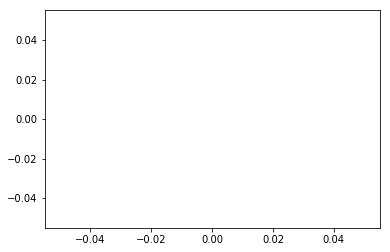

In [29]:
with open('loss', 'rb') as f:
    loss = pickle.load(f)
    
with open('dataset', 'rb') as f:
    ds = pickle.load(f)

plt.plot(pd.Series(loss).rolling(20).mean())
plt.show()

## Validation

Firstly, get metrics for images from the same wells as were used for training. To get predictions for initial pairs of images we will aggregate predictions for crops by getting median value.

In [30]:
test_template = (Pipeline()
    .add_namespace(np, Assemble)
    .smooth(src='uv', dst='uv_2')
    .binarize(src='uv_2', dst='uv_2')
    .to_array(src=['dl', 'uv', 'uv_2'], dst=['dl', 'uv', 'uv_2'], channels='first', dtype='float32')
    .make_crops(src=['dl', 'uv', 'uv_2'], shape=SHAPE[1:], step=100, dst=('dl_crops', 'uv_crops', 'uv2_crops'))
    .call(lambda b: [item.shape[0] for item in b.dl_crops], save_to=B('repeats'))
    .repeat(B('labels'), B('repeats'), save_to=B('labels_crops'))       
    .concatenate(B('dl_crops'), axis=0, save_to=B('dl_crops_conc'))
    .concatenate(B('uv_crops'), axis=0, save_to=B('uv_crops_conc'))
    .concatenate(B('uv2_crops'), axis=0, save_to=B('uv2_crops_conc'))
    .concatenate([B('dl_crops_conc'), B('uv_crops_conc'), B('uv2_crops_conc')], axis=1, save_to=B('crops_conc'))    
    .predict_model('model', B('crops_conc'), targets=B('labels_crops'), fetches='proba',
                   save_to=B('proba', mode='w'))
    .assemble(predictions=B('proba'), images=B('dl_crops'),
              mode=['median', 'mean', 'min', 'max'], save_to=B('agg_proba', mode='w'))
    .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                            fmt='proba', axis=-1, save_to=V('metrics', mode='u'))
    .update_variable('stat', (B('dl'), B('uv'), B('uv_2'), B('agg_proba'), B('labels')), mode='a')
    .run(
        batch_size=4,
        n_epochs=1,
        shuffle=False,
        drop_last=False,
        lazy=True,
        bar=False
    )
)

In [31]:
test_before = (Pipeline().before
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:0', 'load/path': 'resnet16.torch'
                })
    .init_variable('loss', init_on_each_run=list)
    .init_variable('proba', init_on_each_run=None)
    .init_variable('metrics', init_on_each_run=None)
    .init_variable('stat', init_on_each_run=list)
)

In [32]:
test_ppl = (test_before + load_ppl + augmentation_ppl + shape_ppl + test_template) << ds.test

In [33]:
test_ppl.run()

In [34]:
metrics = test_ppl.get_variable('metrics')
metrics._confusion_matrix

array([[[59, 95],
        [ 0,  0]]])

In [35]:
for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

specificity : 1.0
sensitivity : 0.0
accuracy : 0.38311688311688313


As we can see,  if we take images from the same dataset the quality is almost perfect.
Now let's check images from new wells with real defects (now we don't drop images with label 1 and don't augment images).

In [43]:
VALIDATION_PATH = '/notebooks/data/test_dataset'
val_index = CoreIndex(path=VALIDATION_PATH)
val_df = read_annotation(VALIDATION_PATH)

val_index = val_index.create_subset(
    np.intersect1d(val_df.index.values, val_index.indices)
)
val_ds = Dataset(val_index, CoreBatch)

val_load_ppl = (Pipeline()
    .load(grayscale=True)
    .create_labels(val_df['QC'])
    .normalize()
)

val_ppl = (test_before + val_load_ppl + shape_ppl + test_template) << val_ds

In [44]:
%%time
val_ppl.run()

KeyboardInterrupt: 

In [45]:
val_metrics = val_ppl.get_variable('metrics')
print(val_metrics._confusion_matrix)

for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', val_metrics.evaluate(m))

[[[96  4]
  [ 0  0]]]
specificity : 1.0
sensitivity : 0.0
accuracy : 0.96


In that case we can see a lot of false positive bu it is connected with not ideal annotation (see [Criticism](#Criticism))

# Training and inference time

Configuration: nvidia gtx 1080.

Training (50 epochs, batch size 8, totally 614 images): 36 min 41 sec

Inference, one epoch (553 images): 41 sec

# Criticism

Let's check errors of the models to understand its problems.

#### False negative

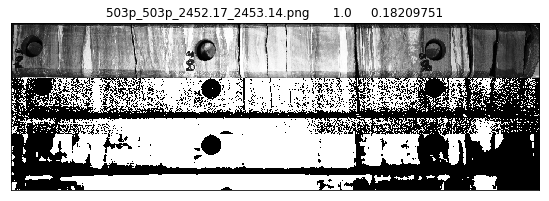

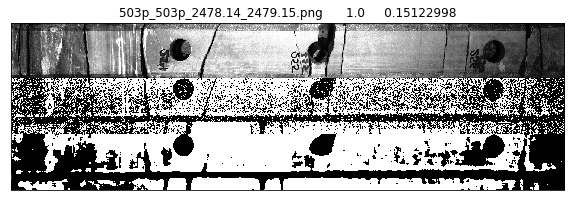

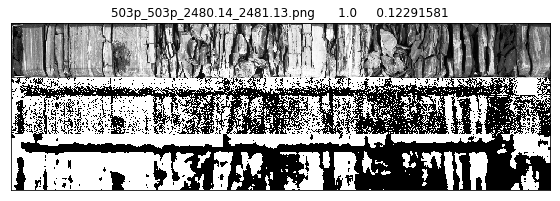

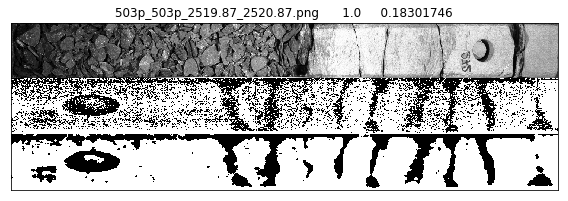

In [46]:
plot_images_predictions(val_ppl, 'fn', n_images=10)

#### False positive

In [47]:
plot_images_predictions(val_ppl, 'fp', n_images=10)

There are a lot of false positive and false negative but that erors were caused by shifts in dataset which were not labeled as defects so model often finds not labeled defects.